In [93]:
import matplotlib.pyplot as plt
import pandas as pd
import json
from pandas.io.json import json_normalize
import math

In [9]:
predictionLabels = []
for i in range(5):
    file_name = '../files/file' + str(i) + '.txt'
    array = []
    with open(file_name) as ins:
        for line in ins:
            array.append(line.rstrip("\n"))
        ins.close()
    predictionLabels.append(array)

In [82]:
artistLabels = []
for i in range(5):
    file_name = '../files/art' + str(i) + '.txt'
    array = []
    with open(file_name) as ins:
        for line in ins:
            array.append(line.rstrip("\n"))
        ins.close()
    artistLabels.append(array)

In [36]:
print len(predictionLabels)
print len(predictionLabels[0])
print predictionLabels[0][500:600]

5
50000
['Little Talks', 'Riptide', 'Dirty Paws', 'Ophelia', 'Mountain Sound', 'Ho Hey', 'Shape of You', 'I Will Wait', 'Crystals', 'Take Me To Church', 'Believer', 'King And Lionheart', 'Stubborn Love', 'Shut Up and Dance', 'Mr. Brightside', 'Radioactive', 'Home', 'Thinking Out Loud', 'Mess Is Mine', 'The Cave', 'Closer', 'Budapest', 'Skinny Love', 'Ride', 'Let It Go', 'Stressed Out', 'Demons', 'Pumped Up Kicks', 'Thunder', 'Little Lion Man', 'Tongue Tied', 'Stolen Dance', 'Flowers In Your Hair', 'Pompeii', 'Let Her Go', 'Midnight City', 'Sweater Weather', 'Georgia', 'Heathens', 'Photograph', 'Do I Wanna Know?', 'The Scientist', 'Roses', 'Counting Stars', 'Viva La Vida', 'Electric Feel', "Don't Let Me Down", 'Breezeblocks', 'Rivers And Roads', 'Fix You', 'Slow It Down', 'Dog Days Are Over', 'Believe', 'Love Love Love', "I'm Yours", 'Cigarette Daydreams', 'Work Song', 'All I Want', 'On Top Of The World', 'A Sky Full of Stars', 'She Will Be Loved - Radio Mix', "Ain't No Rest for the Wic

In [26]:
hidden_df = pd.DataFrame()

In [137]:
def create_test_df(num_hidden_tracks_test, num):
    global hidden_df
    hidden_df = pd.DataFrame()
    file_name = './data/challenge_set.json'

    with open(file_name) as json_file:
        json_data = json.load(json_file)
        for i in range(len(json_data['playlists'])):
            try:
                #json_data['playlists'][i]['tracks'] = json_data['playlists'][i]['tracks'][num:num+50]
                json_data['playlists'][i]['tracks'] = json_data['playlists'][i]['tracks'][-50:]
            except:
                print('WARN: No. of tracks less than the number to be hidden, escaped!') 
                pass
        hidden_df = pd.concat([hidden_df, json_normalize(json_data['playlists'])])

In [133]:
def get_r_precision(ground_truth, predictions):
    count = 0
    for prediction in predictions:
        if prediction in ground_truth:
            count += 1
    return float(count*1.0/len(ground_truth))

In [127]:
def ndcg_score(prediction, truth):
    predictionSet = set(prediction)
    truthSet = set(truth)
    intersect = len(predictionSet & truthSet)
    
    df_score = pd.DataFrame()
    df_score['predictionUri']=prediction
    df_score['trueUri']=truth
    
    ranking=[]
    ntracks = len(truth)
    #print ntracks
    
    for index,row in df_score.iterrows():
        if row.predictionUri in df_score.trueUri.values:
            ranking.append(1)
        else:
            ranking.append(0)
    
    #Calculating the score
    df_score['rel']=ranking
    df_score['ind']=df_score.index+2
    df_score['logVal']=np.log2(df_score['ind'])
    DCGscore = (df_score['rel'].divide(df_score['logVal'])).sum()
    den = df_score['logVal'][0:intersect]
    df_score['one']=1
    num = df_score['one'][0:intersect]
    IDCGscore = (num.divide(den)).sum()
    if IDCGscore==0:
        NDCGscore = 0
    else:
        NDCGscore = DCGscore*1.0/IDCGscore
    return NDCGscore

In [134]:
def ndcg_score2(prediction, truth):
    collected = set([])
    predSet = set(prediction)
    truthSet = set(truth)
    
    idcg = 1
    for i in range(2, len(predSet & truthSet)):
        idcg += (1/float(math.log10(i)/math.log10(2)))
    
    dcg = 0
    if prediction[0] in truthSet:
        collected.add(prediction[0])
        dcg += 1
        
    for i in range(1, len(prediction)):
        if prediction[i] in collected:
            continue
        if prediction[i] in truthSet:
            collected.add(prediction[i])
            dcg += (1/(float)(math.log10(i+1)/math.log10(2)))
            
    return float(dcg)/idcg

In [138]:
r_prec = []
arts = []
ndcgs = []
ndcgs_arts = []
count = 0
arr = [100, 200, 300, 400, 500]
types = [99, 95, 90, 75, 50]
num_playlists = 100
for index in range(5):
    hidden_df = pd.DataFrame()
    create_test_df(types[index], 100-types[index])
    
    precision_values = []
    ndcg_values=[]
    precision_values_artist = []
    ndcg_values_artist = []
    
    for i in range(len(arr)):
        total_r_precision = 0
        total_ndcg = 0
        total_r_precision_artist = 0
        total_ndcg_artist = 0
        curr = 0
        for index1, row1 in hidden_df.iterrows():
            if count >= num_playlists:
                count=0
                break
            count += 1
            r_precision = get_r_precision(set([track['track_name'] for track in hidden_df.loc[index1]['tracks']]), 
                                          predictionLabels[index][curr:curr+arr[i]])
            total_r_precision += r_precision
            
            ndcg_ =  ndcg_score2(predictionLabels[index][curr:curr+arr[i]], [track['track_name'] for track in hidden_df.loc[index1]['tracks']])
            total_ndcg= total_ndcg + ndcg_
            
            r_precision_artist = get_r_precision(set([track['artist_name'] for track in hidden_df.loc[index1]['tracks']]), 
                                          set(artistLabels[index][curr:curr+arr[i]]))
            total_r_precision_artist += r_precision_artist
            
            ndcg_artist =  ndcg_score2(artistLabels[index][curr:curr+arr[i]], [track['artist_name'] for track in hidden_df.loc[index1]['tracks']])
            total_ndcg_artist= total_ndcg_artist + ndcg_artist
            
            curr += 500
        precision_values.append(total_r_precision/num_playlists)
        ndcg_values.append(total_ndcg/num_playlists)
        precision_values_artist.append(total_r_precision_artist/num_playlists)
        ndcg_values_artist.append(total_ndcg_artist/num_playlists)
        
    r_prec.append(precision_values)
    arts.append(precision_values_artist)
    ndcgs.append(ndcg_values)
    ndcgs_arts.append(ndcg_values_artist)

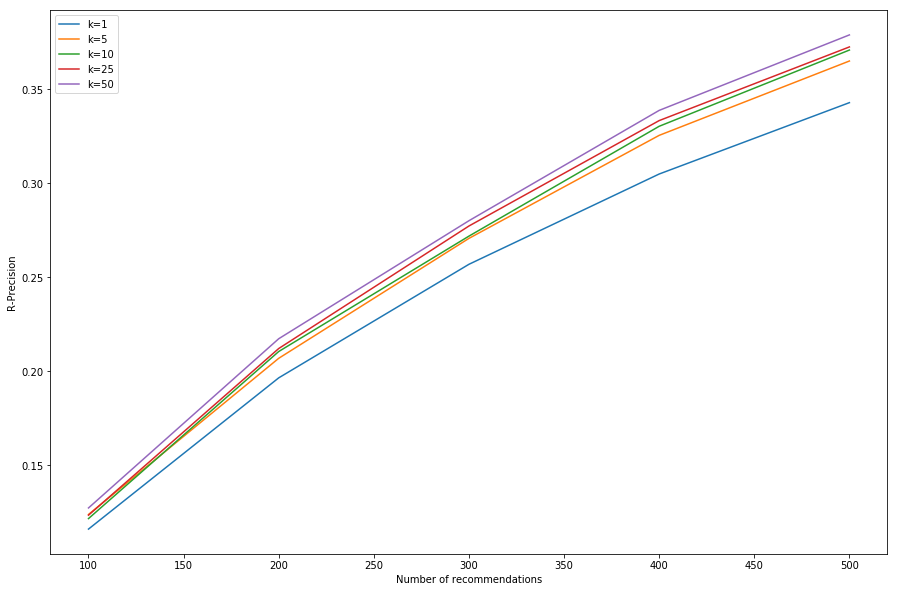

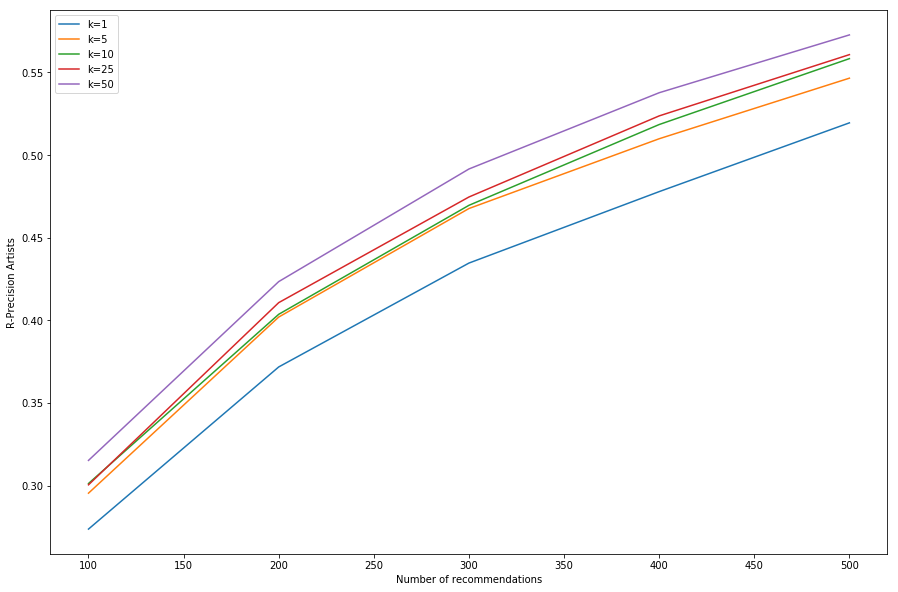

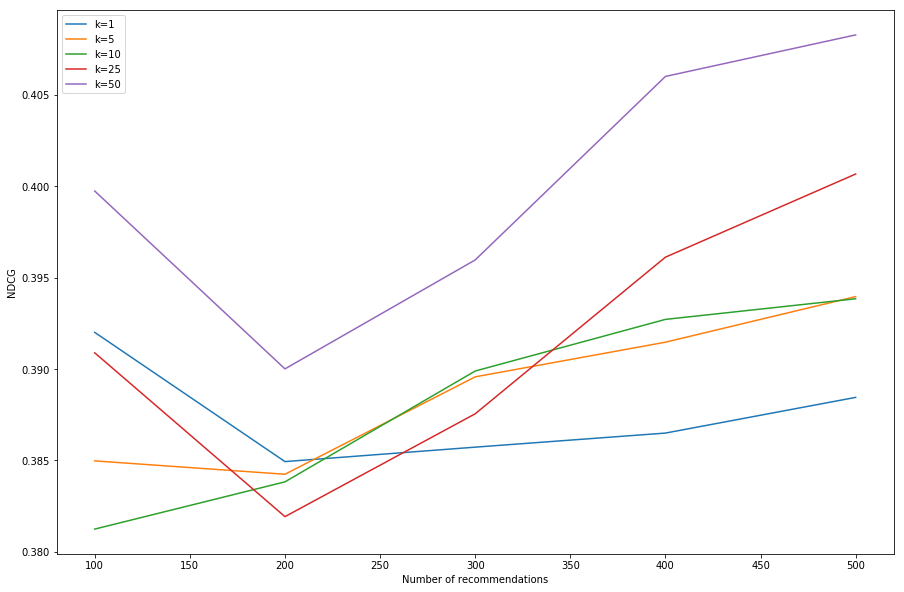

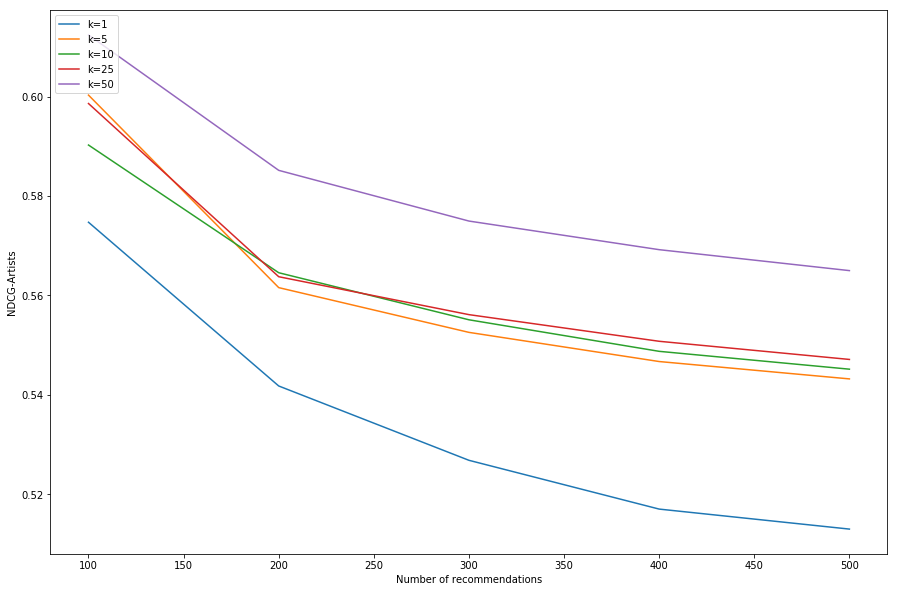

In [144]:
plt.figure(figsize=(15,10))
for i in range(5):
    plt.plot(arr, r_prec[i], label="k="+str(100-types[i]))
    
plt.legend(loc='upper left')
plt.xlabel('Number of recommendations')
plt.ylabel('R-Precision')
plt.savefig('r_prec')
plt.show()

plt.figure(figsize=(15,10))
for i in range(5):
    plt.plot(arr, arts[i], label="k="+str(100-types[i]))
    
plt.legend(loc='upper left')
plt.xlabel('Number of recommendations')
plt.ylabel('R-Precision Artists')
plt.savefig('r_prec_artist')
plt.show()



plt.figure(figsize=(15,10))
for i in range(5):
    plt.plot(arr, ndcgs[i], label="k="+str(100-types[i]))
    
plt.legend(loc='upper left')
plt.xlabel('Number of recommendations')
plt.ylabel('NDCG')
plt.savefig('ndcg')
plt.show()

plt.figure(figsize=(15,10))
for i in range(5):
    plt.plot(arr, ndcgs_arts[i], label="k="+str(100-types[i]))
    
plt.legend(loc='upper left')
plt.xlabel('Number of recommendations')
plt.ylabel('NDCG-Artists')
plt.savefig('ndcg_artists')
plt.show()

In [150]:
print "R-Precision:", r_prec[4][4]
print "Artists R-Precision:", arts[4][4]
print "NDCG:", ndcgs[4][4]
print "NDCG Artists:", ndcgs_arts[4][4]

R-Precision: 0.378790202131
Artists R-Precision: 0.572721112456
NDCG: 0.408286103448
NDCG Artists: 0.564970863152
